# Imports

In [ ]:
import transformers
import numpy as np
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
from tqdm import tqdm
import torch
from scipy.optimize import minimize
import matplotlib.pyplot as plt

transformers.logging.set_verbosity_error()

# Load Model


In [ ]:
model_name = 'Qwen/Qwen2.5-0.5B-Instruct' #Put the SLM you want here (not too big if you don't have collab gpu)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# LogProber functions

In [ ]:
from logging import logProcesses
# Get logprobabilities on a given text
def get_logp(model,tokenizer,text):
  #get the logp for each token in text
  logp = []
  input_ids = tokenizer.encode(text)
  logits = model(torch.tensor(input_ids).unsqueeze(0)).logits
  logps = torch.nn.functional.log_softmax(logits[0,-len(input_ids):],dim=-1)
  for i in range(len(input_ids)-1):
    logp.append(logps[i,input_ids[i+1]].item())
  return [0]+logp

def plot_cumlogp(logp,tokens,show=True):
  plt.plot([0]+np.cumsum(logp[1:]).tolist(),label='data')
  plt.xticks(np.arange(len(tokens)),tokens,rotation='vertical')
  if show:
    plt.show()

def fit_model(logp):
  logp = [0]+np.cumsum(np.array(logp)[1:])
  def loss(logp,params):
    n = len(logp)
    A,B = params
    x = np.arange(len(logp))/n
    y = -A*(1-np.exp(-B*x))
    l = ((logp/n-y)**2).mean()
    return l
  A,B = minimize(lambda params : loss(logp,params),np.array([1,1]),method='BFGS',tol=10**-20).x
  return A,B

def plot_model(A,B,show=True):
  n = len(logp)
  x = np.arange(len(logp))/n
  y = -A*(1-np.exp(-B*x))
  plt.plot(x*n,y*n,label='model',linestyle='--')
  if show:
    plt.show()

## Individual plot

A: 1.3716613195512755
B: 41.9583695005606


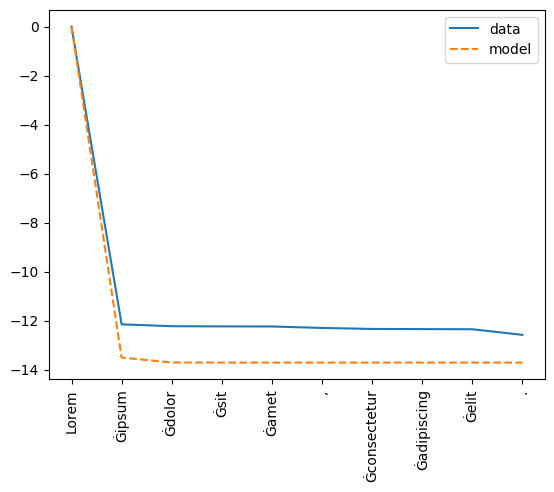

In [ ]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit.'
logp = get_logp(model,tokenizer,text)
tokens = tokenizer.tokenize(text)
plot_cumlogp(logp,tokens,show=False)
A,B = fit_model(logp)
print('A:',A)
print('B:',B)
plot_model(A,B,show=False)
plt.legend()
plt.show()

## Group plot

In [ ]:
famous_texts = ['May the force be with you.', #Star Wars
                'Not all those who wander are lost.', #The Lord of the Ring
                'To be or not to be: that is the question.', #Shakespear
                'The quick brown fox jumps over the lazy dog.',
                'Lorem ipsum dolor sit amet, consectetur adipiscing elit.']
#Invented or taken in the middle of random wikipedia pages without context
random_texts = ['He was posted to Northern Ireland.',
                'Conductor of opera in Russian cities.',
                'This data structure is responsive and compact.',
                'The red carpet is more expensive than the blue one',
                'Most of the species are medium to small-sized spiders.']

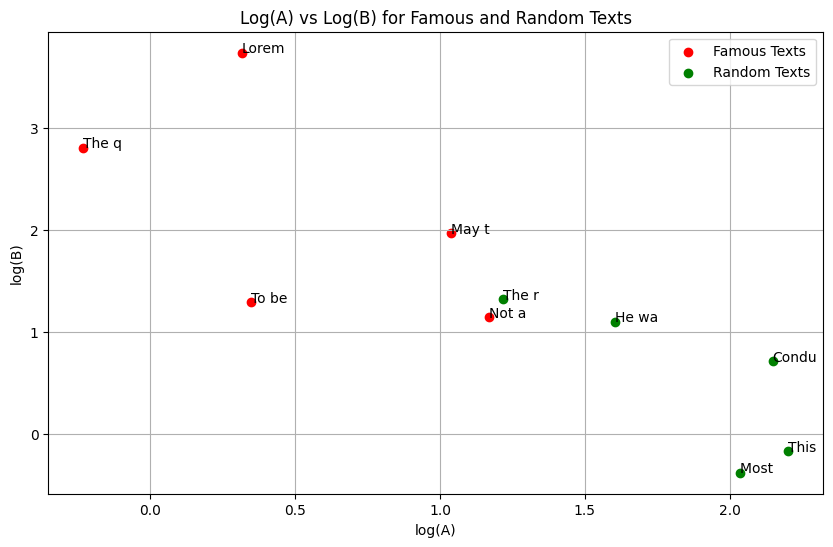

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

logA_famous = []
logB_famous = []
logA_random = []
logB_random = []

for text in famous_texts:
  logp = get_logp(model, tokenizer, text)
  A, B = fit_model(logp)
  logA_famous.append(np.log(A))
  logB_famous.append(np.log(B))

for text in random_texts:
  logp = get_logp(model, tokenizer, text)
  A, B = fit_model(logp)
  logA_random.append(np.log(A))
  logB_random.append(np.log(B))

plt.figure(figsize=(10, 6))
plt.scatter(logA_famous, logB_famous, color='red', label='Famous Texts')
plt.scatter(logA_random, logB_random, color='green', label='Random Texts')

for i, text in enumerate(famous_texts):
  plt.annotate(text[:5], (logA_famous[i], logB_famous[i]))

for i, text in enumerate(random_texts):
  plt.annotate(text[:5], (logA_random[i], logB_random[i]))

plt.xlabel('log(A)')
plt.ylabel('log(B)')
plt.title('LogProber for Famous and Random Texts')
plt.legend()
plt.grid(True)
plt.show()
